## Name: David Freilich
## Andrew ID: dfreilic

# PART I Generative Adversarial Networks (GANs)

## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session



## Reading Dataset


Extracting ./datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
(16, 784)


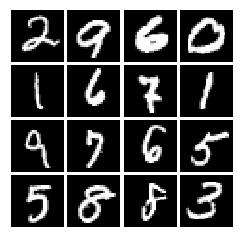

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./datasets/MNIST_data', one_hot=False)
print(mnist.train.next_batch(16)[0].shape)
# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU

In [16]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
#     return tf.nn.leaky_relu(x, alpha)
    return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

## Random Noise


In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform(shape=[batch_size, dim], minval=-1, maxval=1)


## Discriminator

In [11]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        dense1 = tf.layers.dense(inputs=x, units=256)
        leaky1 = leaky_relu(dense1)
        dense2 = tf.layers.dense(inputs=leaky1, units=256)
        leaky2 = leaky_relu(dense2)
        dense3 = tf.layers.dense(inputs=leaky2, units=1)
        return dense3

## Generator

In [12]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        dense1 = tf.layers.dense(inputs=z, units=1024, activation=tf.nn.relu)
        dense2 = tf.layers.dense(inputs=dense1, units=1024, activation=tf.nn.relu)
        dense3 = tf.layers.dense(inputs=dense2, units=784, activation=tf.nn.tanh)
        return dense3        

# GAN Loss function


In [13]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    D_loss, G_loss = None, None
    # TODO: compute D_loss and G_loss
    # Target label vector for generator loss and used in discriminator loss.
    labels_real = tf.ones_like(logits_real)
    labels_fake = tf.zeros_like(logits_fake)
    labels_gen_fake = tf.ones_like(logits_fake)
    
    # DISCRIMINATOR loss has 2 parts: how well it classifies real images and how well it
    # classifies fake images.
    d_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=labels_real)
    d_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=labels_fake)
    # Combine and average losses over the batch
    D_loss = tf.reduce_mean(d_real_loss) + tf.reduce_mean(d_fake_loss)
    
    # GENERATOR is trying to make the discriminator output 1 for all its images.
    # So we use our target label vector of ones for computing generator loss.
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=labels_gen_fake))
    # Average generator loss over the batch.
    return D_loss, G_loss

# Optimizers

In [14]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    lr = 1e-3
    beta_1=0.5
    D_solver = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta_1)
    G_solver = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta_1)
    return D_solver, G_solver

## Putting it all together
 Read over this section and section below carefully to understand how we'll be composing the generator and discriminator

In [17]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!

In [18]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

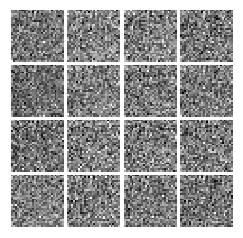


Iter: 0, D: 1.18, G:0.7113
Iter: 50, D: 1.966, G:0.4121
Iter: 100, D: 1.234, G:0.9886
Iter: 150, D: 0.7312, G:1.535
Iter: 200, D: 0.7774, G:1.504


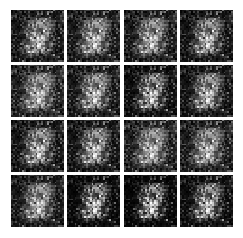


Iter: 250, D: 1.142, G:1.533
Iter: 300, D: 1.334, G:0.9808
Iter: 350, D: 1.388, G:1.139
Iter: 400, D: 0.7895, G:3.699
Iter: 450, D: 1.175, G:2.001


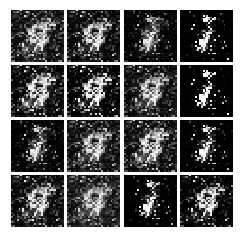


Iter: 500, D: 0.73, G:1.896
Iter: 550, D: 1.309, G:1.327
Iter: 600, D: 1.172, G:0.9776
Iter: 650, D: 1.182, G:2.277
Iter: 700, D: 1.133, G:1.613


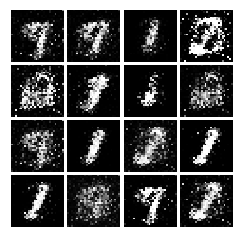


Iter: 750, D: 1.236, G:1.079
Iter: 800, D: 0.976, G:1.321
Iter: 850, D: 1.843, G:1.543
Iter: 900, D: 1.033, G:1.436
Iter: 950, D: 1.413, G:0.5943


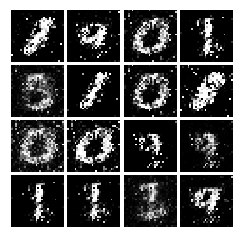


Iter: 1000, D: 1.477, G:1.357
Iter: 1050, D: 1.191, G:1.249
Iter: 1100, D: 1.179, G:1.277
Iter: 1150, D: 1.16, G:1.749
Iter: 1200, D: 1.175, G:1.378


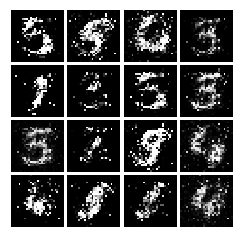


Iter: 1250, D: 1.177, G:1.295
Iter: 1300, D: 1.116, G:1.372
Iter: 1350, D: 1.184, G:1.167
Iter: 1400, D: 1.346, G:0.7692
Iter: 1450, D: 1.246, G:0.8751


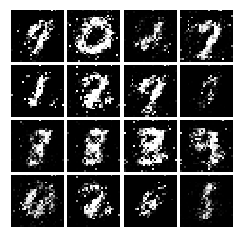


Iter: 1500, D: 1.269, G:1.119
Iter: 1550, D: 1.264, G:1.068
Iter: 1600, D: 1.237, G:1.17
Iter: 1650, D: 1.176, G:1.013
Iter: 1700, D: 1.297, G:0.9178


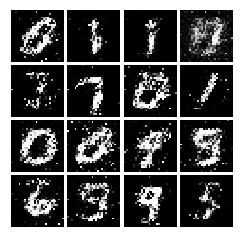


Iter: 1750, D: 1.27, G:0.928
Iter: 1800, D: 1.218, G:0.8966
Iter: 1850, D: 1.285, G:0.8407
Iter: 1900, D: 1.179, G:0.9649
Iter: 1950, D: 1.329, G:0.9309


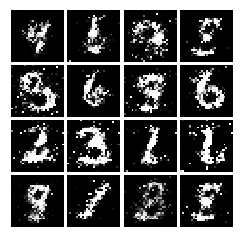


Iter: 2000, D: 1.131, G:0.8612
Iter: 2050, D: 1.272, G:0.9796
Iter: 2100, D: 1.267, G:0.8048
Iter: 2150, D: 1.408, G:0.9501
Iter: 2200, D: 1.263, G:0.9254


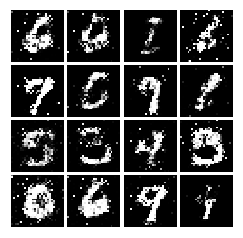


Iter: 2250, D: 1.303, G:0.7913
Iter: 2300, D: 1.336, G:0.9052
Iter: 2350, D: 1.252, G:0.914
Iter: 2400, D: 1.35, G:0.9114
Iter: 2450, D: 1.32, G:0.9144


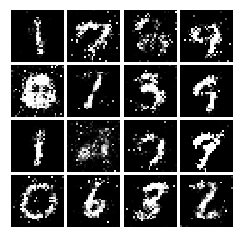


Iter: 2500, D: 1.272, G:0.8405
Iter: 2550, D: 1.302, G:0.8835
Iter: 2600, D: 1.298, G:0.9547
Iter: 2650, D: 1.24, G:0.8491
Iter: 2700, D: 1.252, G:0.9367


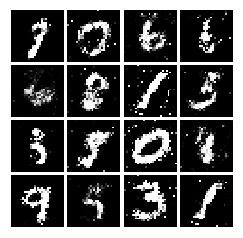


Iter: 2750, D: 1.261, G:0.6598
Iter: 2800, D: 1.233, G:0.8788
Iter: 2850, D: 1.298, G:0.9856
Iter: 2900, D: 1.309, G:0.9287
Iter: 2950, D: 1.223, G:0.8553


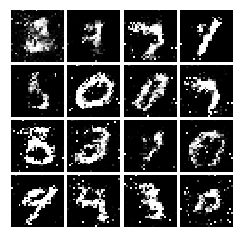


Iter: 3000, D: 1.27, G:0.8029
Iter: 3050, D: 1.302, G:0.8921
Iter: 3100, D: 1.297, G:0.8873
Iter: 3150, D: 1.302, G:0.8636
Iter: 3200, D: 1.399, G:1.003


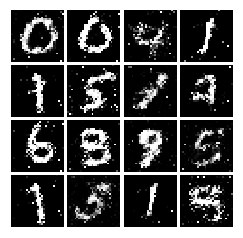


Iter: 3250, D: 1.31, G:0.8514
Iter: 3300, D: 1.261, G:0.85
Iter: 3350, D: 1.354, G:0.8484
Iter: 3400, D: 1.361, G:0.8541
Iter: 3450, D: 1.3, G:0.9103


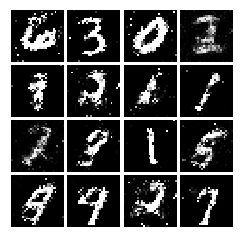


Iter: 3500, D: 1.345, G:0.8261
Iter: 3550, D: 1.278, G:0.8679
Iter: 3600, D: 1.353, G:0.8885
Iter: 3650, D: 1.247, G:0.828
Iter: 3700, D: 1.316, G:0.8069


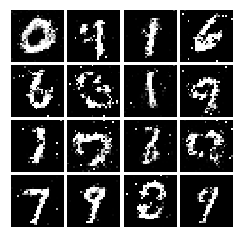


Iter: 3750, D: 1.321, G:0.8719
Iter: 3800, D: 1.302, G:0.8052
Iter: 3850, D: 1.203, G:0.8005
Iter: 3900, D: 1.336, G:0.8636
Iter: 3950, D: 1.331, G:0.8394


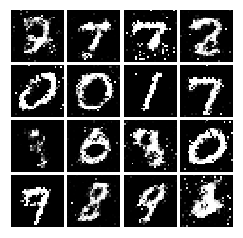


Iter: 4000, D: 1.336, G:0.8741
Iter: 4050, D: 1.287, G:0.8661
Iter: 4100, D: 1.253, G:0.8821
Iter: 4150, D: 1.3, G:0.8997
Iter: 4200, D: 1.289, G:0.855


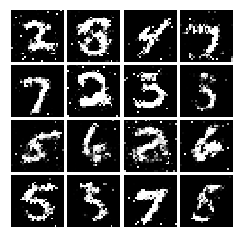


Iter: 4250, D: 1.273, G:0.8051
Final images


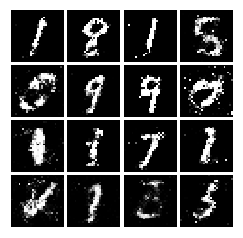

In [19]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

## 2.2 Questions
### Q1 On a high level, what is the difference between L-BFGS attack(page 4 of [2]) and attack introduced in [2]?

The attack introduced in [2], by Carlini, is more flexible than L-BFGS, though there are similarities. Both seek to minimize the distance between x and x' (represented differently by each), and both reformulate it (_minimize c · || x − x' ||2 + loss( x' )_ __versus__ _D(x, x + δ) + c · f(x + δ))_ to include an additional loss factor, mapping the generated image to a value. One difference, based on their formulations, is that while L-BFGS introduces a constant __c__ modifying the distance term, Carlini keeps the Distance term clean, and uses the constant __c__ to modify the function term (f(x + δ). 

On a larger scale, L-BFGS was typically used with a cross-entropy loss function modifying the distance,  while Carlini introduces an objective function __f__, designed so that _C(x + δ) = t_ if and only if _f(x + δ) ≤ 0_, with 7 different functions. Ultimately, while L-BFGS typically uses a cross-entropy loss function, Carlini formulized it as an __optimization problem__ (rather than a gradient problem), minimizing _f(x') = max(max{Z(x')[i]: i != t} − Z(x')t, −κ)_.

### Q2 On a high level, what is the difference from the defenses mentioned in 2 (such as defensive distillation) and the defense of 3? Why do you think 3 can successfully defend against the attack in 2?

Saraubh/Feinman used Deep Manifold representation as the core of his defense, noting that adversarial samples lie off of the true data manifold, and using that to generate a defense. This is different from the other defenses mentioned, like defensive distillation, which were more focused on reducing overfitting. To gauge whether an example was on the manifold, Feinman uses _density estimates_ of the last hidden layer and _Bayesian uncertainty estimates_ to check. 

I think that 3 can succesfully defend against the attack from 2 (C&W), because the product of the attack was still not quite on the manifold of the target class, and had a different uncertainty distribution, being an artificial image. 